In [1]:
import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

from collections import namedtuple
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import data_processing as dp
import model
import model_utilities as util
import vocab
import batch_samplers

Impossible to import Faiss library!! Switching to standard nearest neighbors search implementation, this will be significantly slower.



In [3]:
import os

In [4]:
import importlib

In [5]:
import sklearn
from sklearn.metrics import log_loss, accuracy_score

In [6]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [7]:
def get_probs(transformation, model, embeddings, batch_size, use_cuda):
    result = []
#     embed_sum = 0.0
#     squares_sum = 0.0
    embeds = []
    for position in range(0, len(embeddings), batch_size):
        x = embeddings[position:position + batch_size]
        x = torch.autograd.Variable(torch.from_numpy(x)).float()
        if use_cuda:
            x = x.cuda()
        
        x = transformation(x)
        _, probs = model.discriminator.forward(x)
        probs = probs.data.cpu().numpy()
        result.append(probs)
        
        x = x.cpu().data.numpy()
#         embed_sum += x
        embeds.append(x)
    
    result = np.vstack(result)
    z = 1 - result
    result = np.hstack([z, result])
    return result, np.vstack(embeds)

In [8]:
def build_confusion_matrix(predicted_probs, true_y):
    n_labels = predicted_probs.shape[1]
#     assert true_y.shape == predicted_probs.shape
    result = np.zeros(shape=(n_labels, n_labels))
    
    pred = predicted_probs.argmax(axis=1)
#     true = true_y.argmax(axis=1)
    true = true_y
    
    for pred_cls in range(n_labels):
        for true_cls in range(n_labels):
            result[true_cls, pred_cls] = np.count_nonzero(true[pred == pred_cls] == true_cls)
#     norm = result.sum(axis=1)
#     norm = np.maximum(norm, 1)
#     result /= norm[:, None]
    return result


In [10]:
def validate(model, embeddings_1, embeddings_2, batch_size, use_cuda):
    probs_1, t1 = get_probs(model.transform1, model, embeddings_1, batch_size, use_cuda)
    probs_2, t2 = get_probs(model.transform2, model, embeddings_2, batch_size, use_cuda)
    probs = np.vstack([probs_1, probs_2])
    
    pred_1 = probs_1.argmax(axis=1).reshape(-1, 1)
    pred_2 = probs_2.argmax(axis=1).reshape(-1, 1)    
    pred = np.vstack([pred_1, pred_2])
    
    y_true = np.concatenate([np.zeros((len(pred_1),)), np.ones((len(pred_2)))])
    
    
    acc = accuracy_score(y_pred=pred, y_true=y_true)
    loss = log_loss(y_pred=probs, y_true=y_true)
    cm = build_confusion_matrix(probs, y_true)
    
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    
    plt.legend()
    plt.show()
    

    plt.hist(probs[y_true == 0, 1], bins=100, label="0", color='blue')
    plt.hist(probs[y_true == 1, 1], bins=100, label="1", color='orange')
    
    plt.legend()
    plt.show()
    
    t = np.vstack([t1, t2])
    
    return acc, loss, cm, probs, y_true , t
    

In [19]:
import json
import os

In [15]:
config_file = "../experiment_configurations/with_cls_en_es_config_with_criterion.json"
with open(config_file, "r") as f:
    config = json.loads(f.read())
    global_config = config["global_config"]
    model_params = config["model_params"]
    training_params = config["training_params"]

In [17]:
    ROOT = global_config["root"]
    TRAINED_MODELS_FOLDER = os.path.join(ROOT, global_config["trained_models"])
    DATASET_DIR = os.path.join(ROOT, global_config["data"])

In [18]:
    vocab1, all_labels, sents1, labels1 = dp.load_problem(lang=model_params["src_lang"], max_sent_length=model_params["max_sent_length"], 
                                                            data_path=DATASET_DIR, embeddings_file_name=model_params["embeddings_1_file_name"], 
                                                            texts_file_name=model_params["texts_1_file_name"], 
                                                            labels_file_name=model_params["labels_1_file_name"], topics_file_name=model_params["topics_1_file_name"]
                                                            )
    vocab2, all_labels, sents2, labels2 = dp.load_problem(lang=model_params["tgt_lang"], max_sent_length=model_params["max_sent_length"],
                                                            data_path=DATASET_DIR, embeddings_file_name=model_params["embeddings_2_file_name"], 
                                                            texts_file_name=model_params["texts_2_file_name"], 
                                                            labels_file_name=model_params["labels_2_file_name"], topics_file_name=model_params["topics_2_file_name"]
                                                            )
    vocab1.embeddings = dp.normalize_embeddings(vocab1.embeddings)
    vocab2.embeddings = dp.normalize_embeddings(vocab2.embeddings)


In [25]:
!ls $TRAINED_MODELS_FOLDER/en-es_with_classifier_2500_save_embeddings/experiment@2018-05-11_10_22_44

README.txt	debug_logs	stdout_logs	   validation_metrics.pkl
all_params.pkl	model_state.tc	tgt_best.vec
config.json	src_best.vec	train_metrics.pkl


In [27]:
vocab1_ = dp.Vocab(os.path.join(TRAINED_MODELS_FOLDER, "en-es_with_classifier_2500_save_embeddings", "experiment@2018-05-11_10_22_44", "src_best.vec"))

In [28]:
vocab2_ = dp.Vocab(os.path.join(TRAINED_MODELS_FOLDER, "en-es_with_classifier_2500_save_embeddings", "experiment@2018-05-11_10_22_44", "tgt_best.vec"))

In [29]:
embeds1 = vocab1_.embeddings
embeds2 = vocab2_.embeddings

/data/itasarom/torch/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


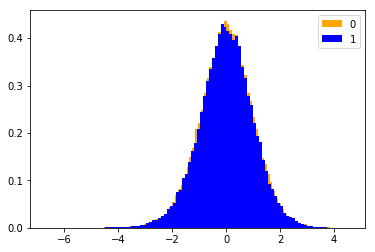

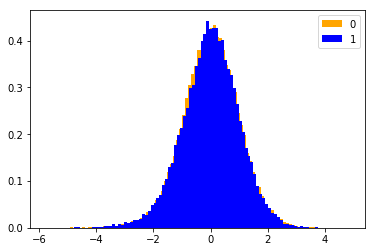

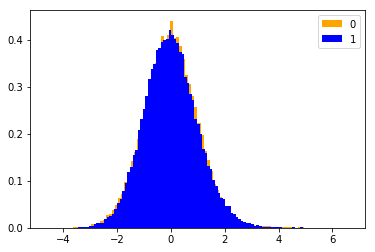

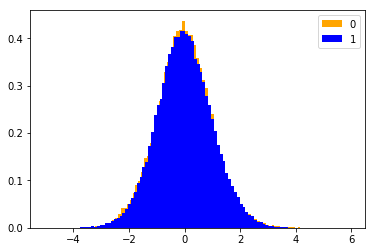

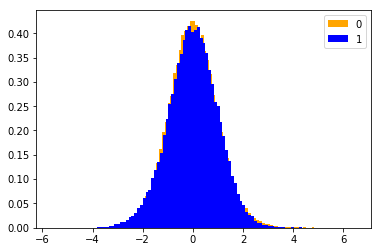

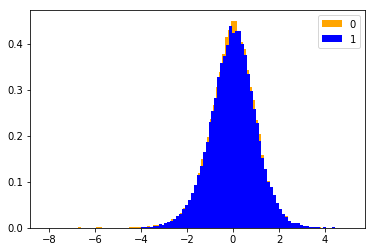

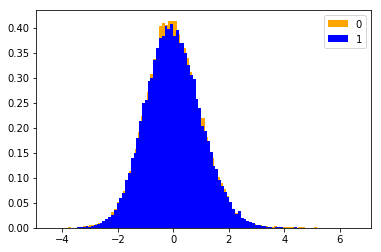

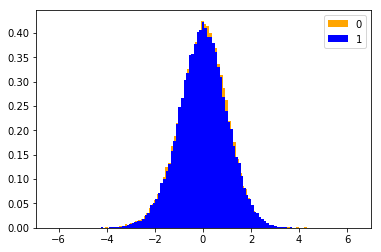

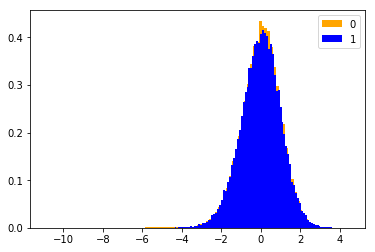

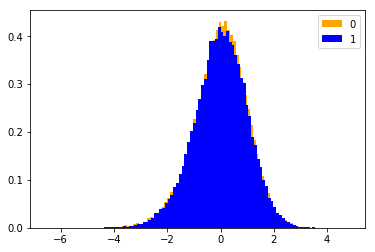

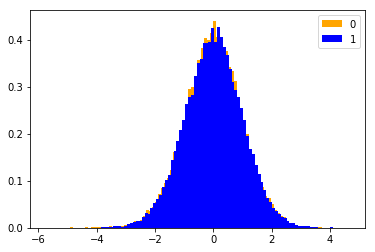

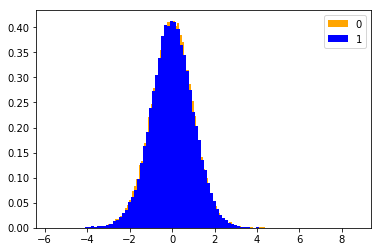

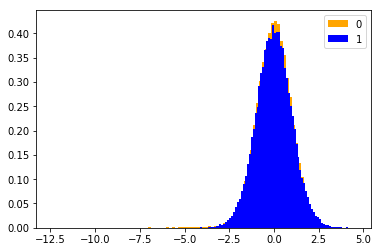

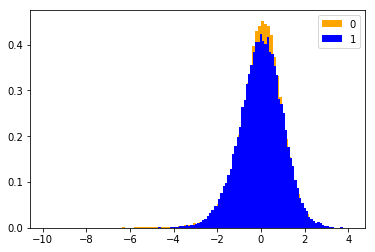

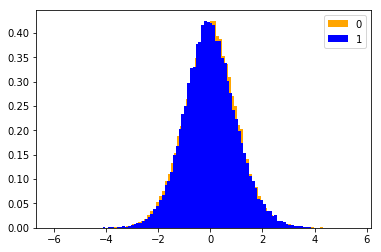

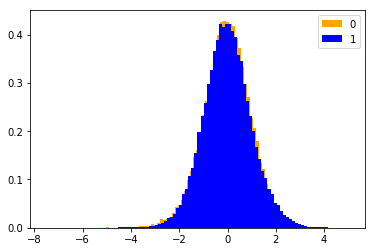

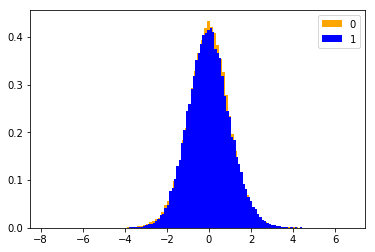

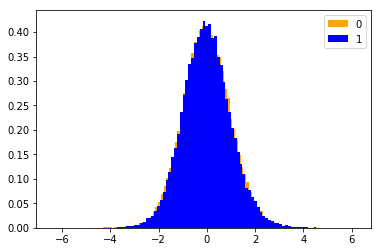

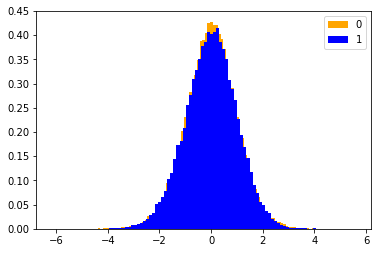

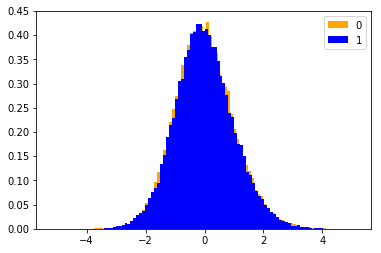

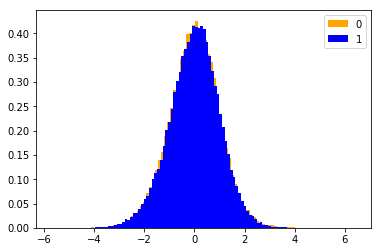

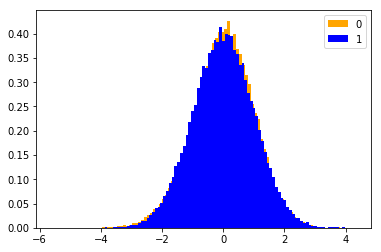

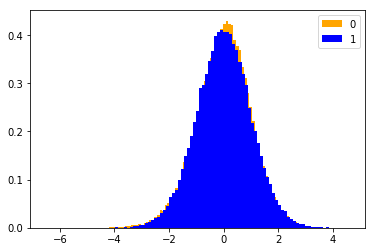

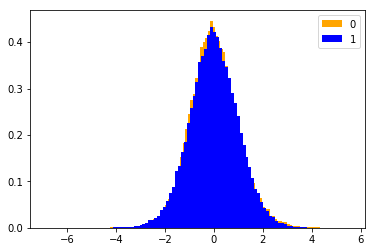

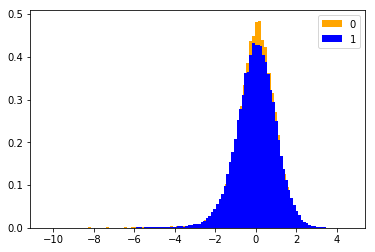

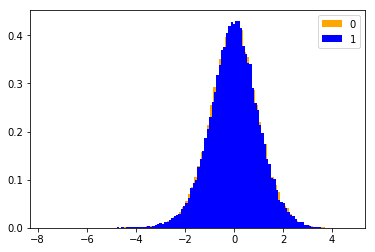

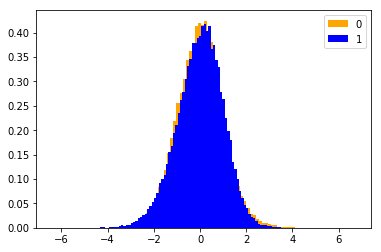

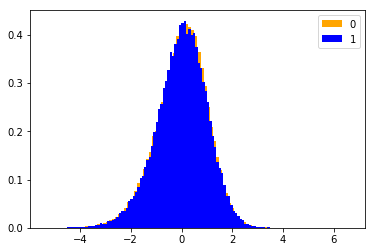

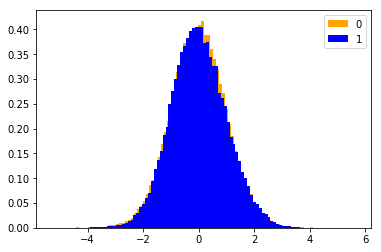

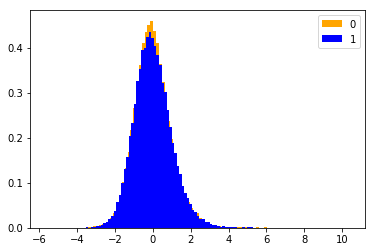

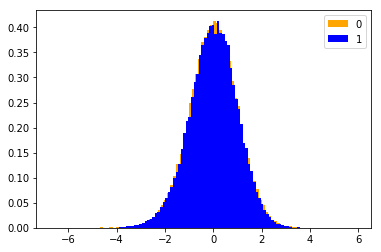

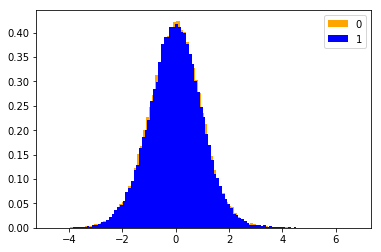

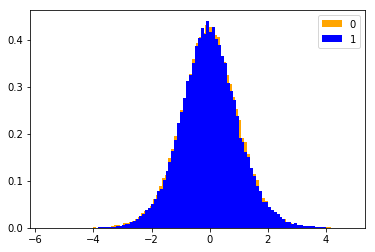

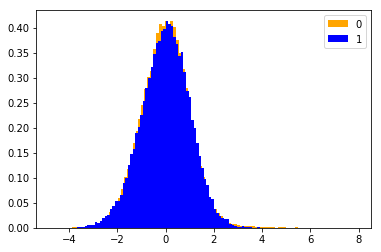

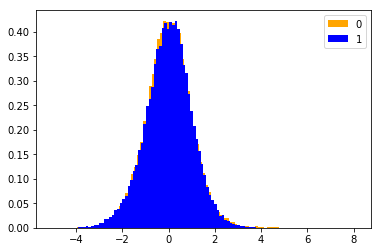

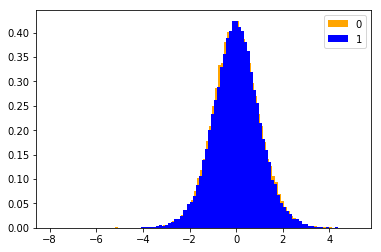

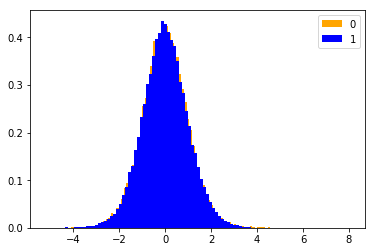

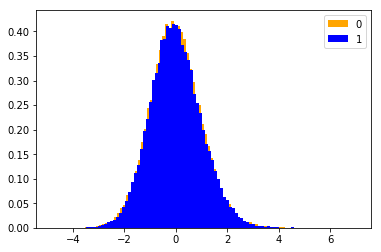

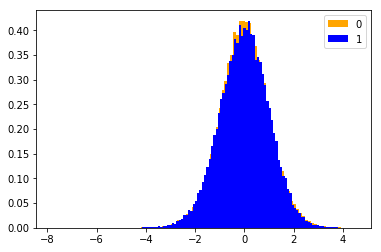

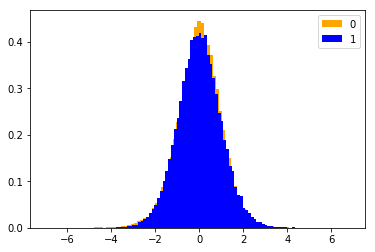

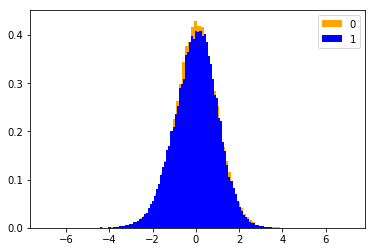

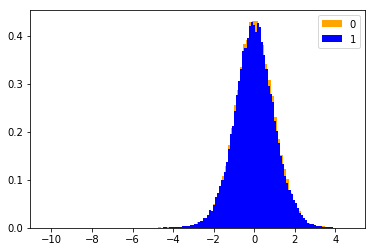

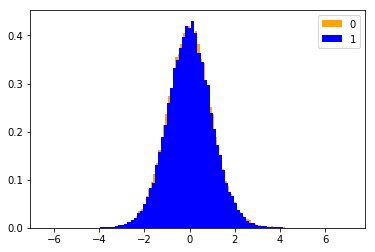

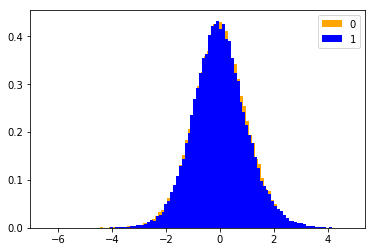

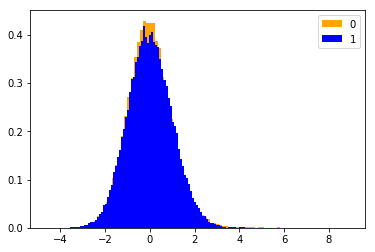

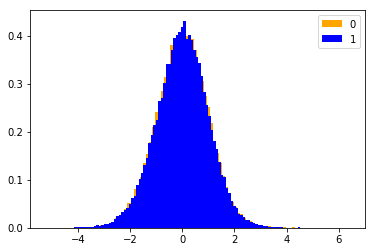

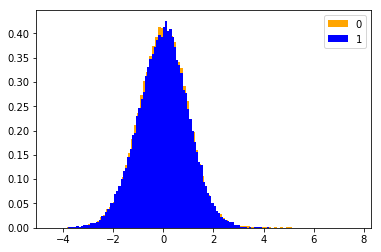

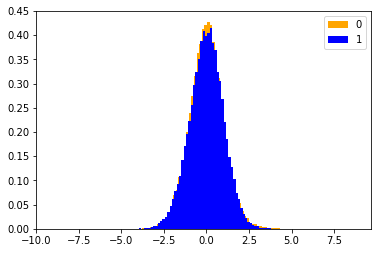

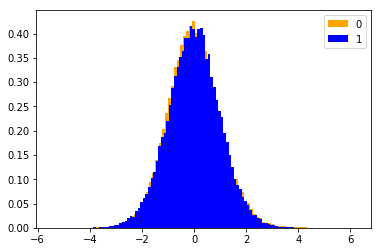

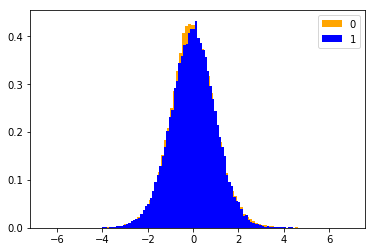

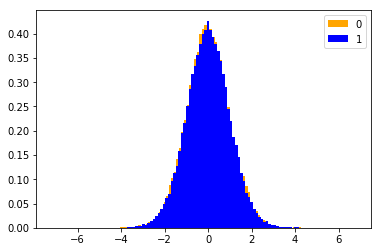

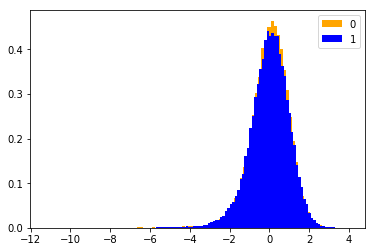

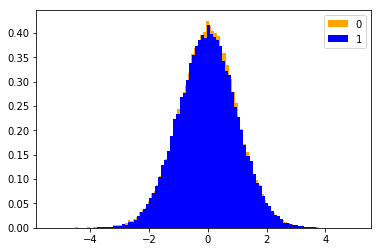

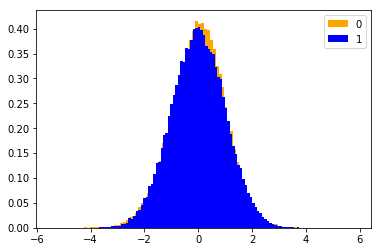

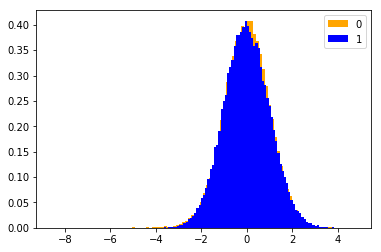

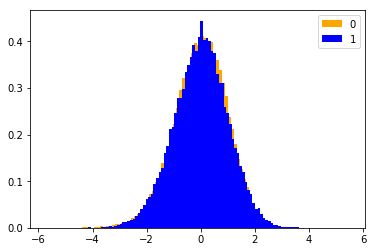

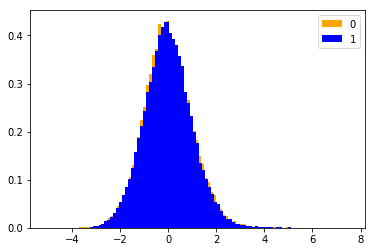

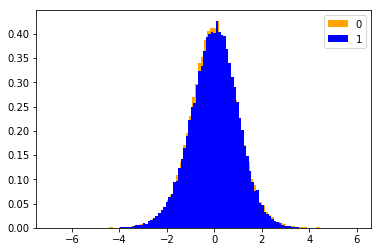

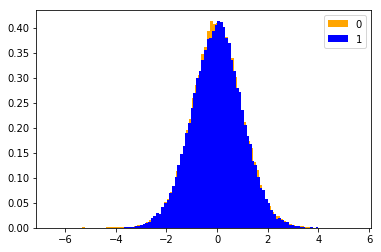

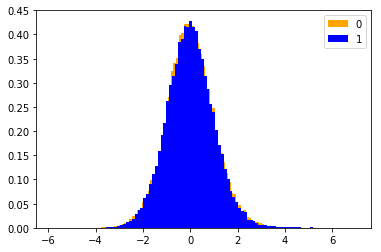

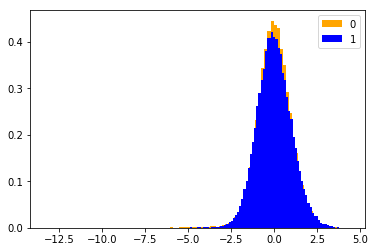

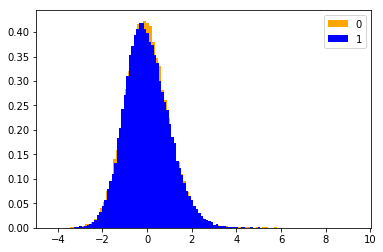

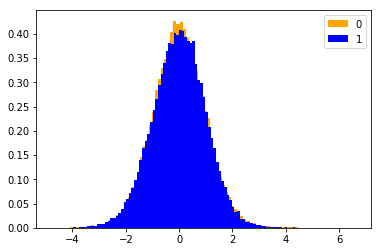

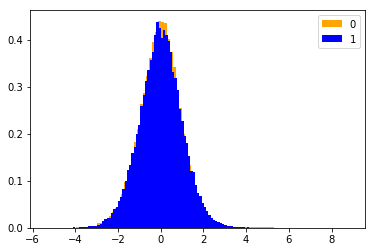

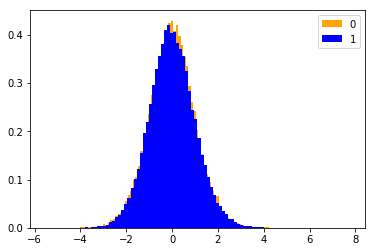

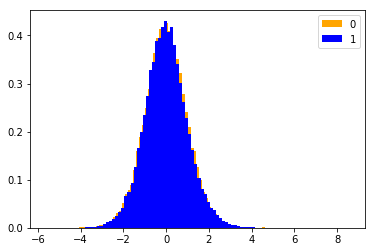

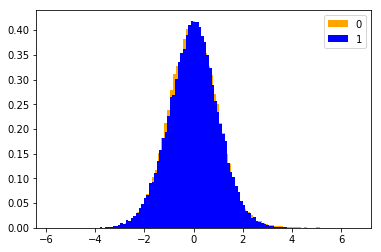

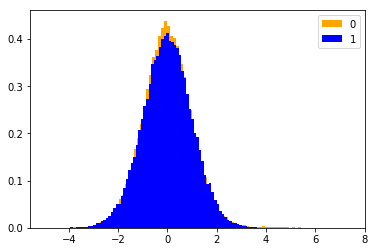

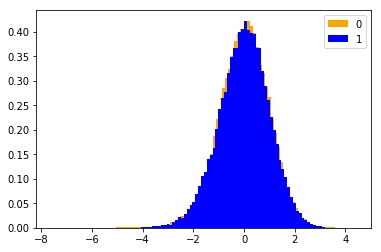

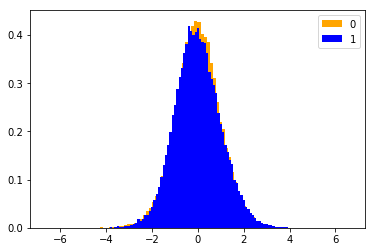

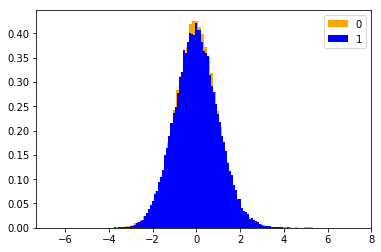

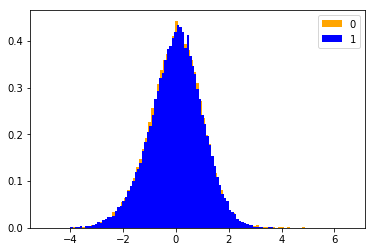

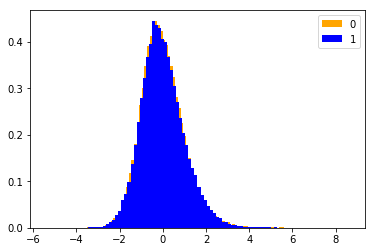

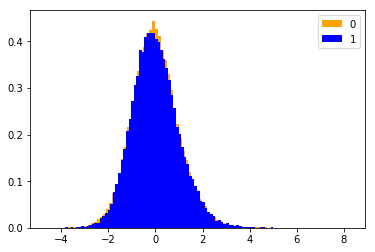

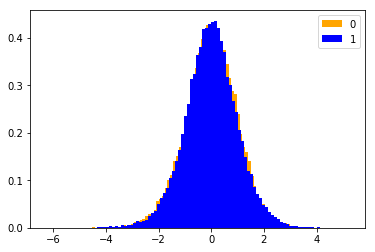

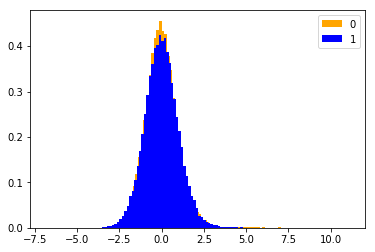

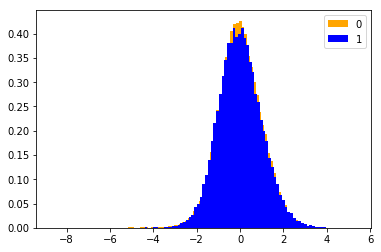

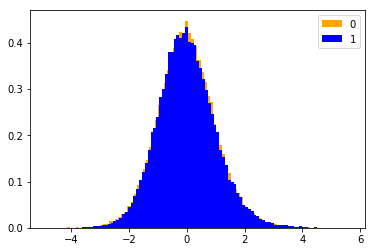

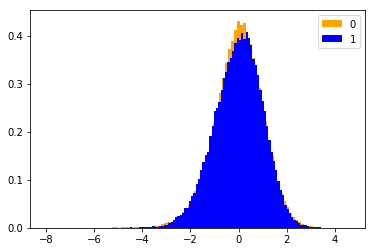

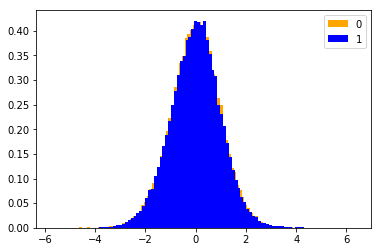

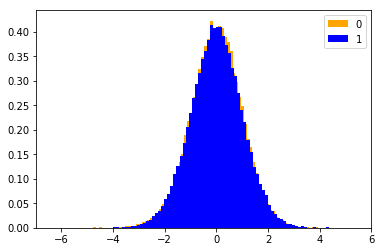

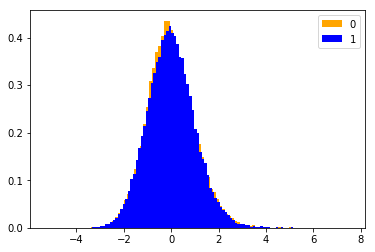

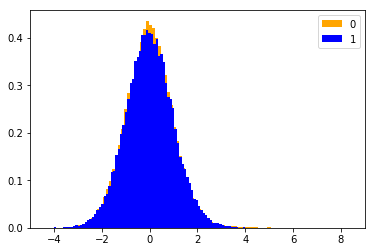

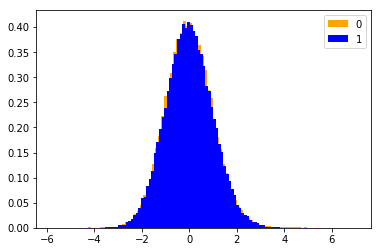

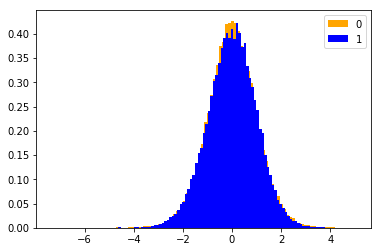

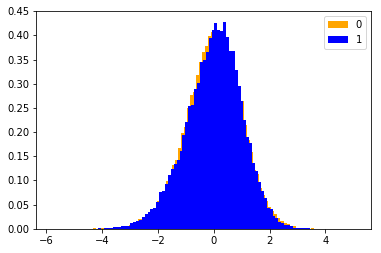

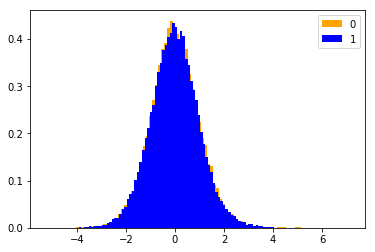

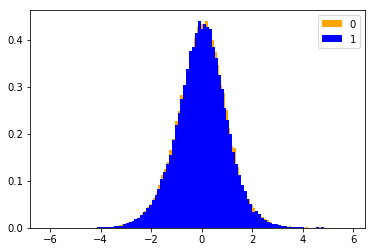

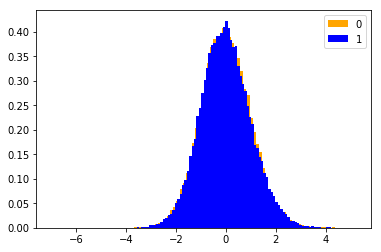

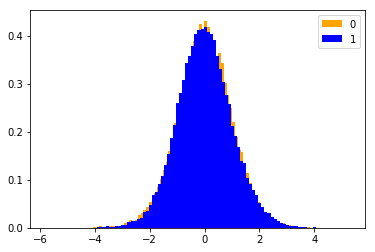

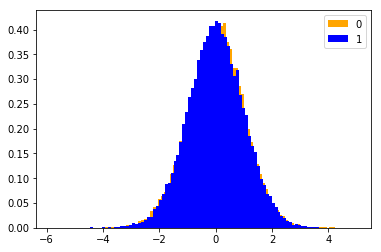

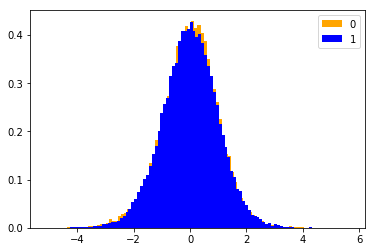

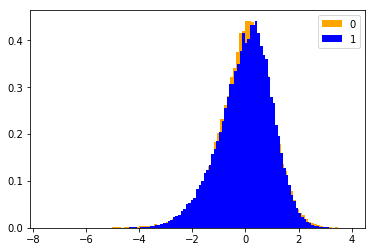

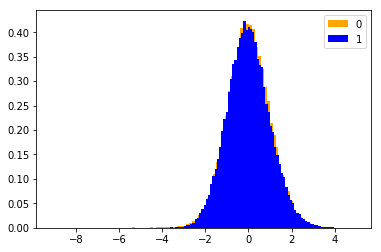

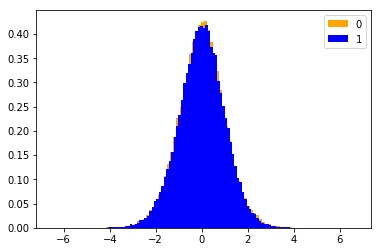

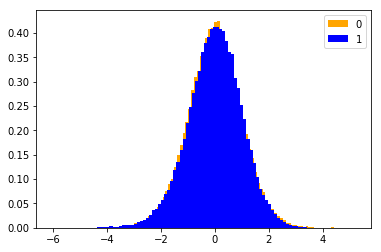

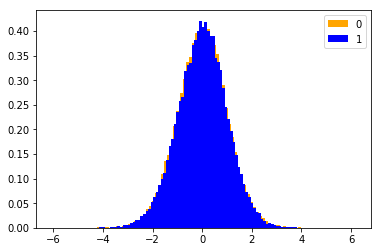

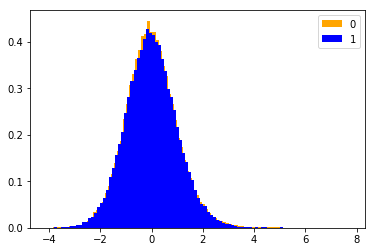

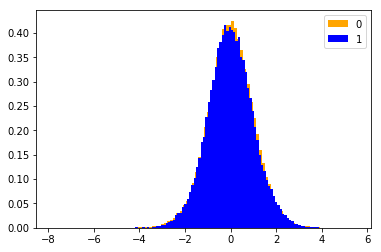

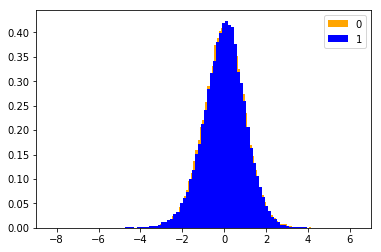

In [30]:
for i in range(100):
    plt.hist(embeds1[:, i], color='orange', bins=100, label='0', normed=True)
    plt.hist(embeds2[:, i], color='blue', bins=100, label='1', normed=True)
    plt.legend()
    plt.show()

In [33]:
f = """
aider
famille
groupe
regarder
posséder
président
haut
homme
venir
octobre
gros
chaque
chose
femme
trouver
publique
campagne
eau
gauche
bien
pays
jamais
"""
f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [86]:
s ="""
ayudar
familia
grupo
mira
poseer
presidente
alto
hombre
venir
octubre
grande
cada
cosa
mujer
encontrar
público
campaña
agua
izquierda
bueno
país
nunca
"""

f = [w.strip() for w in s.split("\n") if len(w) > 1]


s = """
help
family
group
look
own
president
high
man
come
october
big
every
thing
woman
find
public
campaign
water
left
good
country
never
"""
s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [87]:
# s ="""
# enero
# febrero
# marzo
# abril
# mayo
# junio
# julio
# agosto
# septiembre
# octubre
# noviembre
# diciembre
# """

# f = [w.strip() for w in s.split("\n") if len(w) > 1]


# s = """
# january
# february
# march
# april
# may
# june
# july
# august
# september
# october
# november
# december
# """
# s = [w.strip() for w in s.split("\n") if len(w) > 1]

In [88]:
s, f = f, s

In [36]:
# def plot_word_by_id(t1, t2, e, f, ids, dims):
#     plt.figure(figsize=(20, 20))
# #     plt.scatter(t1[ids, 0], t1[ids, 1], color='r')
# #     plt.scatter(t2[ids, 0], t2[ids, 1], color='b')
#     plt.xlim(-3, 3)
#     plt.ylim(-3, 3)
#     for id in ids:
#         plt.annotate(e[id], (t1[id, dims[0]], t1[id, dims[1]]), color='r', fontsize=15)
#         plt.annotate(f[id], (t2[id, dims[0]], t2[id, dims[1]]), color='b', fontsize=15)
# #     plt.annotate(e)
# #         print(id)
#     plt.show()

In [37]:
def get_point(id, embeds, dims):
    return embeds[id, dims[0]], embeds[id, dims[1]]

def plot_word_by_id(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, dims, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        if not hide_original:
            plt.annotate(w1, get_point(id, orig1, dims), color='black', fontsize=15)
            plt.annotate(w2, get_point(id, orig2, dims), color='grey', fontsize=15)
        plt.annotate(w1, get_point(id, t1, dims), color='r', fontsize=15)
        plt.annotate(w2, get_point(id, t2, dims), color='b', fontsize=15)

        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [38]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[1, 2], hide_original=True)

In [39]:
# plot_word_by_id(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, dims=[12, 49], hide_original=True)

In [40]:
# e = """
# help
# family
# group
# look
# own
# president
# high
# man
# come
# october
# big
# every
# thing
# woman
# find
# public
# campaign
# water
# left
# good
# country
# never
# """
# e = [w.strip() for w in e.split("\n") if len(w) > 1]

In [41]:
# f = """
# aider
# famille
# groupe
# regarder
# posséder
# président
# haut
# homme
# venir
# octobre
# gros
# chaque
# chose
# femme
# trouver
# publique
# campagne
# eau
# gauche
# bien
# pays
# jamais
# """
# f = [w.strip() for w in f.split("\n") if len(w) > 1]

In [42]:
# cls = cls.cpu()
from sklearn.decomposition import PCA

In [43]:
def get_point_pca(id, embeds):
    return embeds[id, 0], embeds[id, 1]

def plot_words_pca(pca, vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2, hide_original=False):
    plt.figure(figsize=(20, 20))
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)
    ind_2 = vocab2.transform_one(lang_2)
    
    orig1 = pca.transform(orig1[ind_1])
    orig2 = pca.transform(orig2[ind_2])
    t1 = pca.transform(t1[ind_1])
    t2 = pca.transform(t2[ind_2])
    
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    for id, (w1, w2) in enumerate(zip(lang_1, lang_2)):
        
        if not hide_original:
            plt.annotate(w1, get_point_pca(id, orig1), color='black', fontsize=15)
            plt.annotate(w2, get_point_pca(id, orig2), color='grey', fontsize=15)
        plt.annotate(w1, get_point_pca(id, t1), color='r', fontsize=15)
        plt.annotate(w2, get_point_pca(id, t2), color='b', fontsize=15)
        
        
#     plt.annotate(e)
#         print(id)
    plt.show()

In [44]:
# pca1 = PCA(n_components=2)
# pca1.fit(vocab1.embeddings)

In [45]:
# pca2 = PCA(n_components=2)
# pca2.fit(vocab2.embeddings)

In [46]:
# pca3 = PCA(n_components=2)
# pca3.fit(embeds1)

In [47]:
# pca4 = PCA(n_components=2)
# pca4.fit(embeds2)

In [66]:
pca = PCA(n_components=2)
pca.fit(np.vstack([embeds1, embeds2]))
# pca.fit(np.vstack([embeds2]))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

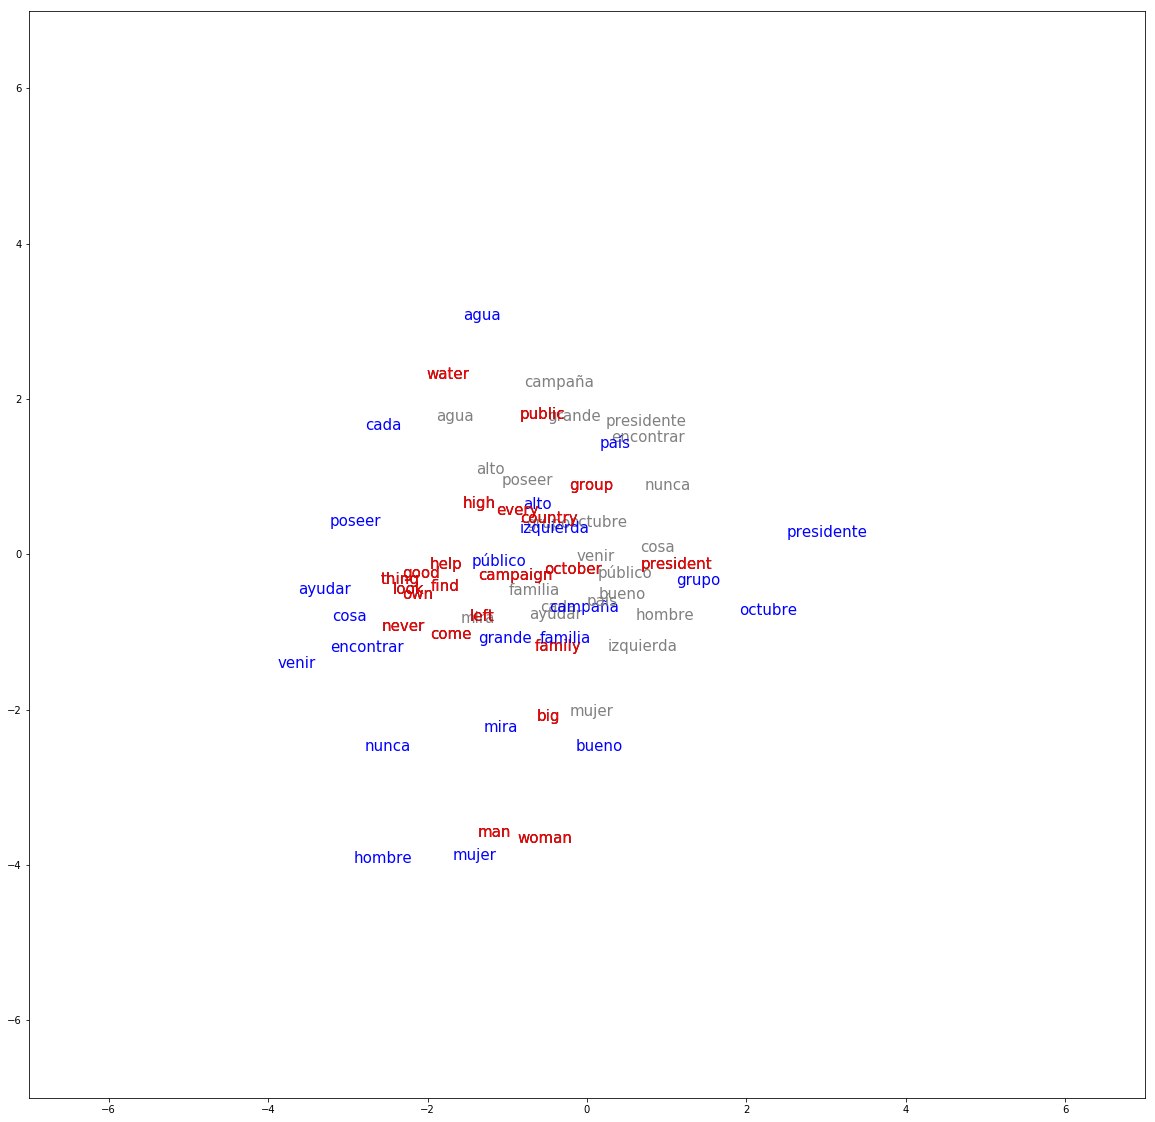

In [89]:
plot_words_pca(pca, vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, hide_original=False)

In [90]:
# vocab1.words[91:150]

In [91]:
from sklearn.metrics.pairwise import cosine_similarity

In [92]:
import seaborn as sns

In [93]:
# f

In [94]:
def cos(a, b):
    a = a/(a**2).sum(axis=1, keepdims=True)**0.5
    b = b/(b**2).sum(axis=1, keepdims=True)**0.5
    
    return (a * b).sum(axis=1)

def cosine_metrics(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    before = cos(orig1, orig2)
    after = cos(t1, t2)
    
    print("{}|{}|{}|{}".format("lang1", "lang2", "before", "after", fill=' ', align='<', width=10))
    for w1, w2, c1, c2 in zip(lang_1, lang_2, before, after):
        print("{}|{}|{:.4f}|{:.4f}".format(w1, w2, c1, c2, fill=' ', align='<', width=10))
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    plt.figure(figsize=(15, 15))
    sns.heatmap(c1, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2, vmin=-1.0, vmax=1.0, square=True)
    plt.show()
    
    plt.figure(figsize=(15, 15))
    sns.heatmap(c2 - c1)
    plt.show()
    
#     print(t1.shape, t2.shape)
#     print(c2.shape)
    s = 0
    for id, w1 in enumerate(lang_1):
#         print(c2[id].argmax())
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        s += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(s/len(lang_1))
#     plt.figure(figsize=(15, 15))
#     sns.heatmap((c2 - c1 > 0.1).astype(np.float32))
#     plt.show()
#     print(np.diag(c2))
#     print(np.diag(c1))
#     print()


In [95]:

def word_translation_cosine(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    c1 = cosine_similarity(orig1, orig2)
    c2 = cosine_similarity(t1, t2)
    
    count = 0
    for id, w1 in enumerate(lang_1):
        translation = lang_2[c2[id].argmax()]
        if translation == lang_2[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_2[id]
        print("{} --> {} ({})".format(w1, translation, res))
        
    print(count/len(lang_1))
    
    count = 0
    for id, w2 in enumerate(lang_2):
        translation = lang_1[c2[:, id].argmax()]
        if translation == lang_1[id]:
            res = "OK"
        else:
            res = "Fail"
        count += translation == lang_1[id]
        print("{} --> {} ({})".format(w2, translation, res))
        
    print(count/len(lang_2))



In [96]:
word_translation_cosine(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> encontrar (Fail)
own --> nunca (Fail)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9090909090909091
ayudar --> help (OK)
familia --> family (OK)
grupo --> group (OK)
mira --> look (OK)
poseer --> own (OK)
presidente --> president (OK)
alto --> high (OK)
hombre --> man (OK)
venir --> come (OK)
octubre --> october (OK)
grande --> big (OK)
cada --> every (OK)
cosa --> thing (OK)
mujer --> woman (OK)
encontrar --> find (OK)
público --> public (OK)
campaña --> campaign (OK)
agua --> water (OK)
izquierda --> left (OK)
bueno --> good (OK)
país --> country (OK)
nunca --> never (OK)
1.0


lang1|lang2|before|after
help|ayudar|0.0591|0.6810
family|familia|0.0183|0.6482
group|grupo|0.0535|0.5805
look|mira|0.0569|0.2631
own|poseer|0.0475|0.2219
president|presidente|-0.0324|0.6315
high|alto|0.0782|0.3189
man|hombre|-0.0778|0.5667
come|venir|0.0181|0.4142
october|octubre|0.0116|0.3672
big|grande|-0.0128|0.2927
every|cada|0.0074|0.4006
thing|cosa|-0.0033|0.4952
woman|mujer|0.1033|0.6647
find|encontrar|0.0524|0.6415
public|público|0.0790|0.3941
campaign|campaña|0.0652|0.6661
water|agua|0.0500|0.6760
left|izquierda|0.0386|0.3654
good|bueno|-0.0258|0.3930
country|país|0.0190|0.4713
never|nunca|-0.0212|0.6141


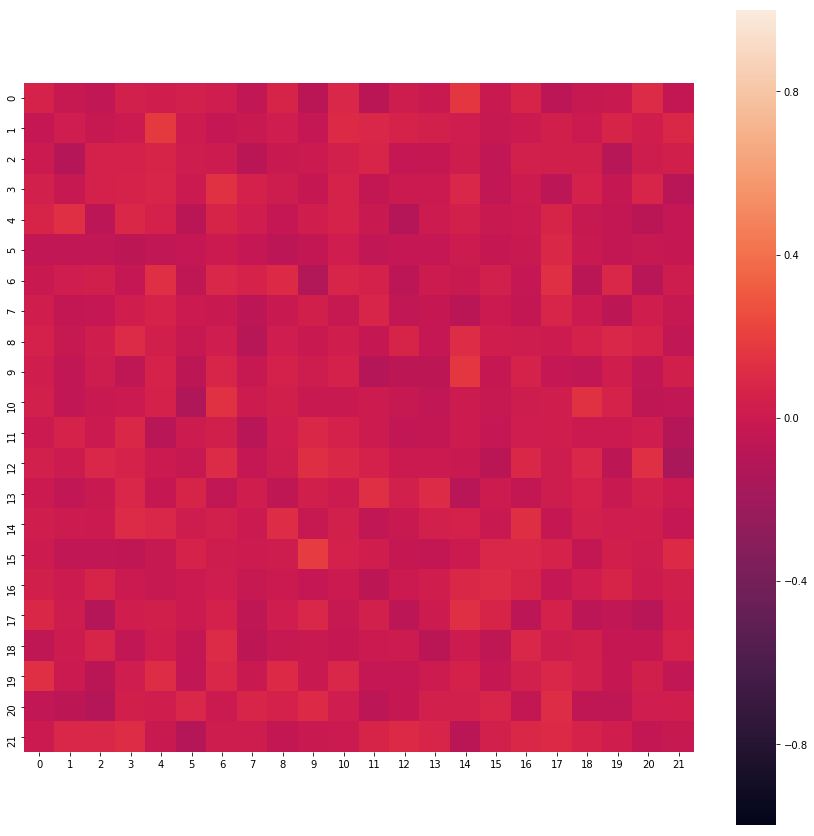

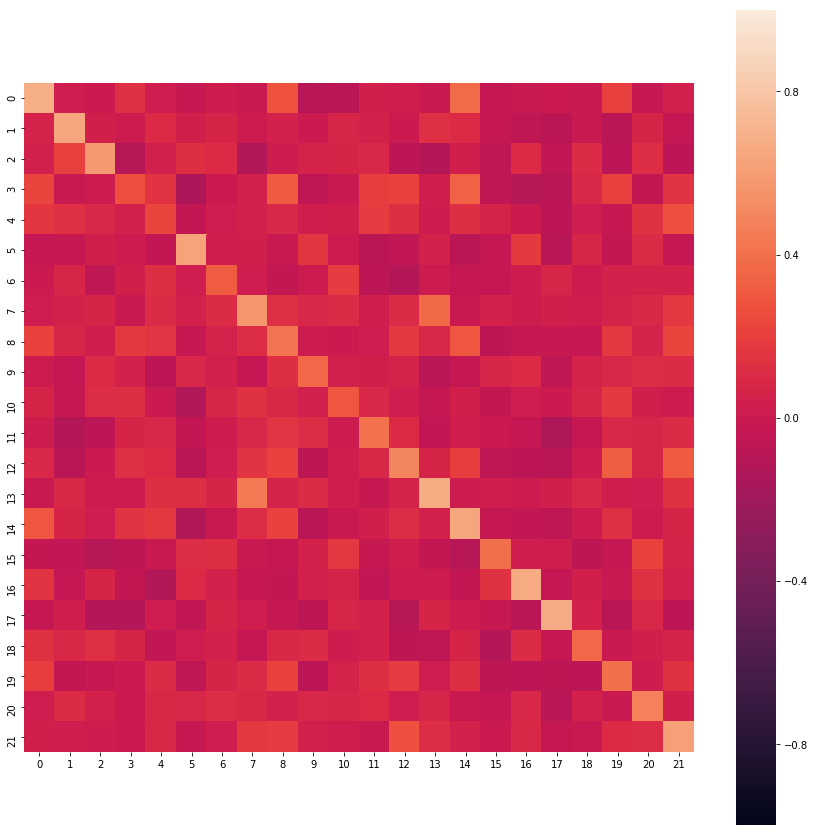

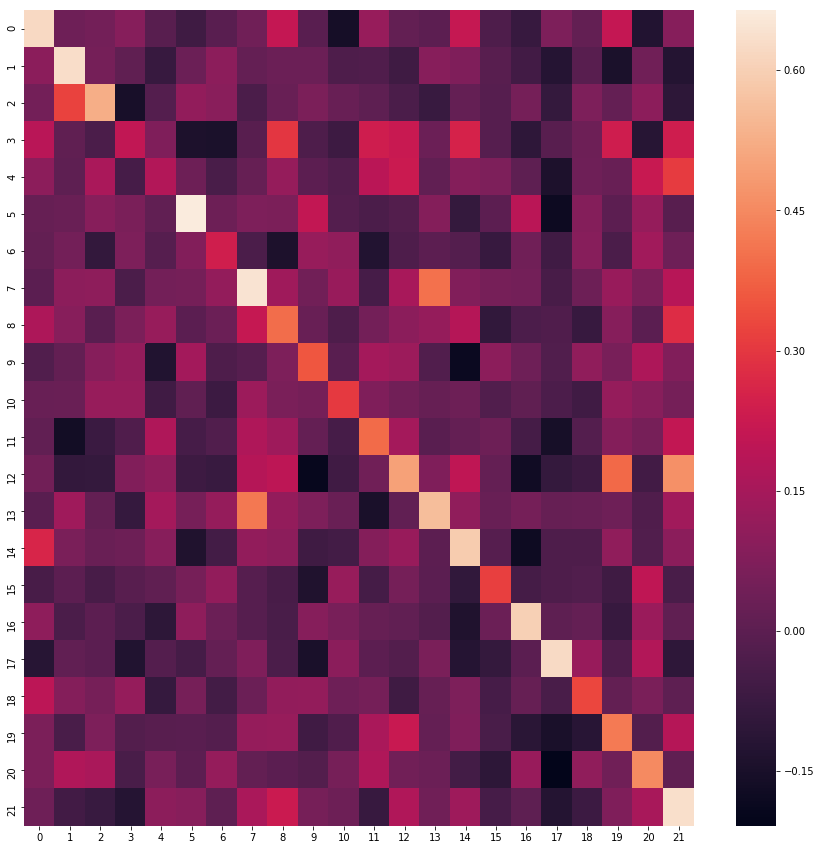

help --> ayudar (OK)
family --> familia (OK)
group --> grupo (OK)
look --> encontrar (Fail)
own --> nunca (Fail)
president --> presidente (OK)
high --> alto (OK)
man --> hombre (OK)
come --> venir (OK)
october --> octubre (OK)
big --> grande (OK)
every --> cada (OK)
thing --> cosa (OK)
woman --> mujer (OK)
find --> encontrar (OK)
public --> público (OK)
campaign --> campaña (OK)
water --> agua (OK)
left --> izquierda (OK)
good --> bueno (OK)
country --> país (OK)
never --> nunca (OK)
0.9090909090909091


In [97]:
cosine_metrics(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s)

In [57]:
# vocab1.transformation

In [58]:
import os
def read_facebook_dict(path, file_name, vocab1, vocab2):
    path = os.path.join(path, file_name)
    
    lang_1 = []
    lang_2 = []
    with open(path, "r") as f:
        for line in f:
            a, b = line.strip().split(" ")
            if a in vocab1.transformation and b in vocab2.transformation:
                lang_1.append(a)
                lang_2.append(b)
                
    return lang_1, lang_2

In [59]:
def word_translation_cosine_silent(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity = cosine_similarity(t1, t2)
    else:
        similarity = cosine_similarity(orig1, orig2)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        candidate_ids = (-similarity[id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        candidate_ids = (-similarity[:, id]).argsort()
        for k in ks:
            if id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [60]:
word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, f, s, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

({1: 0.9090909090909091,
  2: 0.9545454545454546,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0},
 {1: 1.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  50: 1.0,
  100: 1.0,
  200: 1.0,
  500: 1.0,
  1000: 1.0,
  2000: 1.0})

In [61]:
lang_1, lang_2 = read_facebook_dict("../crosslingual/dictionaries/", "en-es.5000-6500.txt", vocab1, vocab2)

In [98]:
lang_1, lang_2 = f, s

In [62]:
# word_translation_cosine_silent(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500,1000, 2000])

In [63]:
def word_translation_cosine_complete(vocab1, vocab2, orig1, orig2, t1, t2, lang_1, lang_2,ks,  use_transformed=True,):
    assert len(lang_1) == len(lang_2)
    ind_1 = vocab1.transform_one(lang_1)[:-1]
    ind_2 = vocab2.transform_one(lang_2)[:-1]
    orig1_complete = orig1
    orig2_complete = orig2
    t1_complete = t1
    t2_complete = t2
    
    orig1 = orig1[ind_1]
    orig2 = orig2[ind_2]
    t1 = t1[ind_1]
    t2 = t2[ind_2]
    
    if use_transformed:
        similarity_1_2 = cosine_similarity(t1, t2_complete)
        similarity_2_1 = cosine_similarity(t2, t1_complete)
    else:
        similarity_1_2 = cosine_similarity(orig1, orig2_complete)
        similarity_2_1 = cosine_similarity(orig2, orig1_complete)
        
    
    counts1 = {k:0 for k in ks}
    for id, w1 in enumerate(lang_1):
        translation_id = vocab2.words.index(lang_2[id])
        candidate_ids = (-similarity_1_2[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts1[k] += 1
        
    counts2 = {k:0 for k in ks}
    for id, w2 in enumerate(lang_2):
        translation_id = vocab1.words.index(lang_1[id])
        candidate_ids = (-similarity_2_1[id]).argsort()
        for k in ks:
            if translation_id in candidate_ids[:k]:
                counts2[k] += 1
        
#     res_for_lang_2 = count/len(lang_2)
    
#     return res_for_lang_1, res_for_lang_2
    for k in ks:
        counts1[k] /= len(lang_1)
        counts2[k] /= len(lang_2)
        
    return counts1, counts2


In [99]:
# word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=False)

In [100]:
word_translation_cosine_complete(vocab1, vocab2, vocab1.embeddings, vocab2.embeddings, embeds1, embeds2, lang_1, lang_2, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], use_transformed=True)

({1: 0.5909090909090909,
  2: 0.5909090909090909,
  3: 0.6363636363636364,
  4: 0.7272727272727273,
  5: 0.7272727272727273,
  6: 0.7727272727272727,
  7: 0.8181818181818182,
  8: 0.8636363636363636,
  9: 0.8636363636363636,
  10: 0.8636363636363636,
  50: 0.9090909090909091,
  100: 0.9090909090909091,
  200: 0.9090909090909091,
  500: 0.9545454545454546,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0},
 {1: 0.5454545454545454,
  2: 0.6818181818181818,
  3: 0.7272727272727273,
  4: 0.7727272727272727,
  5: 0.7727272727272727,
  6: 0.7727272727272727,
  7: 0.7727272727272727,
  8: 0.7727272727272727,
  9: 0.7727272727272727,
  10: 0.7727272727272727,
  50: 0.9090909090909091,
  100: 0.9545454545454546,
  200: 0.9545454545454546,
  500: 0.9545454545454546,
  1000: 1.0,
  2000: 1.0,
  5000: 1.0,
  10000: 1.0,
  20000: 1.0,
  50000: 1.0})